In [1]:
from treeHPYPcts import newick_from_file, RestFranchise, plots,evals, TreeMCMC
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as Colors
from matplotlib.colors import to_hex
from matplotlib import cm
import numpy as np
import random
import pickle
import sys
import os
import scipy as sp
from sklearn.metrics import confusion_matrix, jaccard_score
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline
inline_rc = dict(mpl.rcParams)

/home/steven/anaconda3/envs/treeHPYP/lib/python3.8/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/steven/anaconda3/envs/treeHPYP/lib/python3.8/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?


In [2]:
data_file = 'data/Angio_GIFT_Families_Mean_Seed_Mass.csv'
tree_file = 'data/Angio_GIFT_Families_Mean_Seed_Mass.tree'
result_dir = 'results'
data = pd.read_csv(data_file).iloc[:, 0:2]
data.columns = ['node_name', 'obs']

tree = RestFranchise(newick=newick_from_file(tree_file))
tree.rescale()
mcmc = TreeMCMC(tree, data)
mcmc.load_mcmc(os.path.join(result_dir, 'mcmc.zip'))

If we look at the results under `results/real_data/seed_mass-run2` we can see that there are 3 plausible jump configurations.

In [3]:
summary = []
for f in sorted(os.listdir(os.path.join(result_dir, 'summary'))):
    if f.endswith('.csv'):
        summary.append(pd.read_csv(os.path.join(result_dir, 'summary', f)))

Some configurations have jumps on leaves that do not appear to be important, we can use this function to check how many leaves are affected by each jump and do a filtering.

In [4]:
affected_leaves = []
for s in summary:
    tree.jps = s['predicted_jp'].tolist()
    affected_leaves.append(tree.jp_affected_leave())

In [ ]:
jps_pruned = []
for s, affected in zip(summary, affected_leaves):
    jp = s['predicted_jp']
    # if not jumps then do nothing
    if jp.sum() == 1:
        continue
    mask = affected.loc[affected['nleaf'] <= 5, 'node_idx']
    jp[mask] = 0
    jps_pruned.append(jp.tolist())

In [6]:
unique_jps = np.unique(jps_pruned, axis = 0)

In [7]:
unique_jps.shape

(5, 605)

We can use this function to visualise how the jumps affect the tree.

In [36]:
tree.plot_with_jp(unique_jps[4].tolist())

Now we run our comparisons

In [9]:
lls = mcmc.compare_jps_by_ll(*unique_jps)

In [10]:
avg_ll = []
for x in lls:
    avg_ll.append(sp.special.logsumexp(x[0]+ x[1]) - np.log(1000))

In [11]:
avg_ll

[-397.832652921035,
 -366.57166041973665,
 -368.05272136940323,
 -376.9413174640704,
 -398.21273577536545]

In [12]:
np.argmax(avg_ll)

1

In [7]:
samples = mcmc.bayes_factors_multiple(unique_jps.tolist(), num_chains = 8, parallel=True, n_cores = 5)

In [8]:
samples

[[0, 0, 0, 500, 0],
 [0, 0, 500, 0, 0],
 [0, 500, 0, 0, 0],
 [0, 0, 0, 500, 0],
 [0, 0, 500, 0, 0],
 [0, 500, 0, 0, 0],
 [0, 500, 0, 0, 0],
 [0, 3, 0, 497, 0]]

In [12]:
np.array(samples).mean(axis = 0) / 500

array([0.     , 0.37575, 0.25   , 0.37425, 0.     ])

In [10]:
tree.plot_with_jp(unique_jps[2].tolist(), file = os.path.join(result_dir, 'best3.png'), dpi=600, height =5000, width=5000)

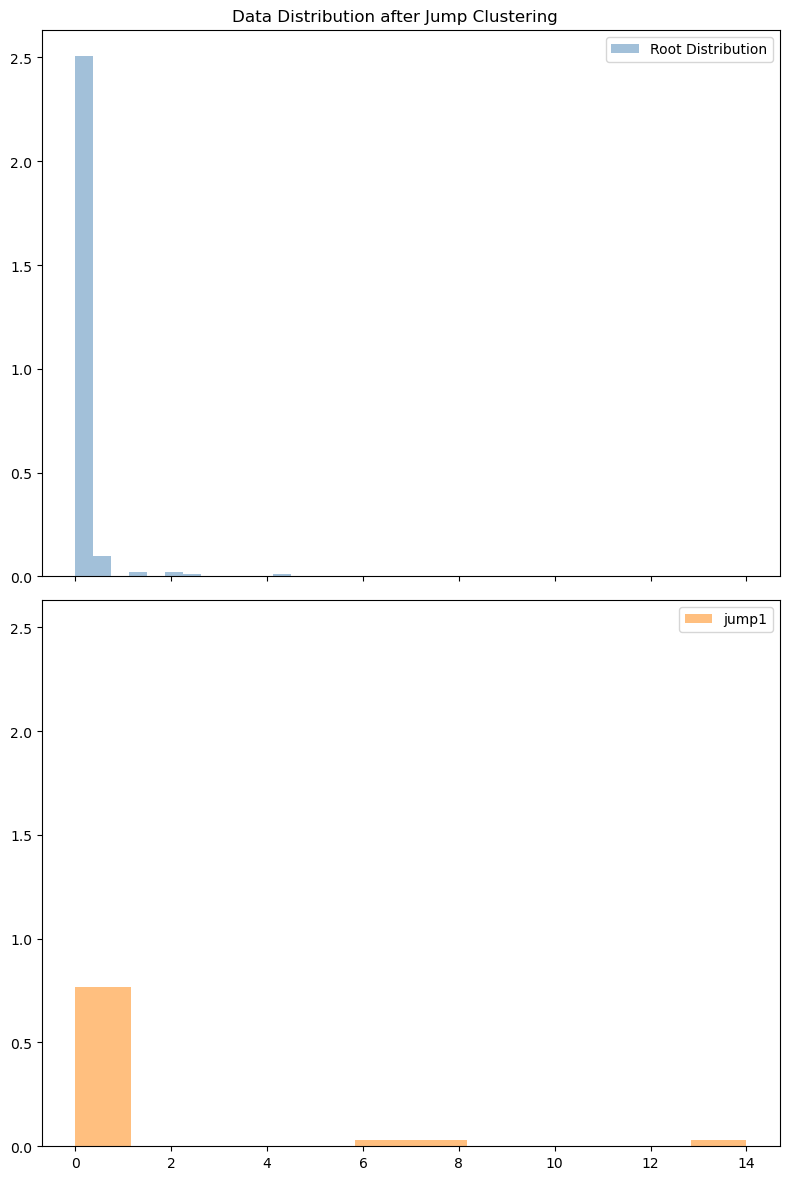

In [11]:
fig, ax = plots.plot_predicted_dist(tree,data,unique_jps[3].tolist(), density=True, kde=False, bins = 12)